In [2]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
# load datasets 
core_2018_0B11 = pd.read_csv("/restricted/projectnb/ma679/ProcessedData/jiafang/revisit_OB112018.csv")
core_2019_0B11 = pd.read_csv("/restricted/projectnb/ma679/ProcessedData/jiafang/revisit_OB112019.csv")


In [3]:
core_2018_0B11.head()

,AGE,FEMALE,PAY1,ZIPINC_QRTL,Diagnosis_Count,Procedure_Count,HCUP_ED,APRDRG_Severity,DMONTH,DISPUNIFORM,response
0,82,0,2,3,14,7,2,3,4,2,0
1,72,0,1,2,17,4,2,3,10,1,0
2,82,1,1,3,30,7,2,4,5,5,1
3,75,0,1,2,22,2,2,4,12,5,1
4,84,0,1,2,18,6,1,4,5,5,0


In [9]:
# Define features and target
X = core_2018_0B11.drop('response', axis=1)  # all columns except 'response'
y = core_2018_0B11['response']

# Create a SMOTE object
sm = SMOTE(random_state=42)

# Resample all classes to the size of the largest class
X_res, y_res = sm.fit_resample(X, y)

# Combine the resampled features and target into one DataFrame
balanced_df = pd.DataFrame(X_res, columns=X.columns)
balanced_df['response'] = y_res

# Shuffle the dataset if necessary
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Now balanced_df contains the oversampled dataset
print(balanced_df.head())


   AGE  FEMALE  PAY1  ZIPINC_QRTL  Diagnosis_Count  Procedure_Count  HCUP_ED  \
0   58       0     3            1               30               25        1   
1   51       1     2            1               15               11        1   
2   47       0     3            1               23                5        2   
3   58       0     3            3               19                9        1   
4   64       1     3            3               17                3        0   

   APRDRG_Severity  DMONTH  DISPUNIFORM  response  
0                4       3            5         1  
1                4       1            5         0  
2                4       5            6         1  
3                3       3            2         1  
4                3       2            5         1  


In [41]:
# Check the distribution of the 'response' variable
distribution = core_2018_0B11['response'].value_counts()

# Display the distribution
print(distribution)


response
0    419
1    163
Name: count, dtype: int64


In [15]:


# Instantiate the Random Forest classifier
# n_estimators is the number of trees in the forest
# max_features='auto' uses sqrt(p) by default
# oob_score=True enables the calculation of the out-of-bag score
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', oob_score=True, random_state=42)


In [16]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid = {
    'max_leaf_nodes': list(range(10, 201, 10))  # Ranging from 10 to 200, step size of 10
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X, y)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500, oob_score=True,
                                              random_state=42),
             param_grid={'max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                            100, 110, 120, 130, 140, 150, 160,
                                            170, 180, 190, 200]},
             scoring='accuracy')

In [17]:
# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# OOB Score of the best model
print("OOB Score:", best_rf.oob_score_)


Best parameters: {'max_leaf_nodes': 10}
OOB Score: 0.7164948453608248


In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score


In [19]:
X_test = core_2019_0B11.drop('response', axis=1)  # all columns except 'response'
y_test = core_2019_0B11['response']
# Predict probabilities
y_prob = grid_search.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Predict class labels for calculating F1 score
y_pred = grid_search.predict(X_test)


In [20]:
# Calculate AUROC
auroc = roc_auc_score(y_test, y_prob)

# Calculate AUPRC
auprc = average_precision_score(y_test, y_prob)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"AUROC: {auroc}")
print(f"AUPRC: {auprc}")
print(f"F1 Score: {f1}")


AUROC: 0.5674182371778045
AUPRC: 0.3228551485302791
F1 Score: 0.0


In [36]:
import xgboost as xgb

# Define XGBoost parameters
params = {
    'learning_rate': 0.01,
    'max_depth': 4,
    'objective': 'binary:logistic',  # Use 'multi:softprob' for multiclass and change num_class
    'eval_metric': 'logloss',  # Can use 'auc' for AUROC, 'logloss' for logistic loss
    'seed': 42
}

# Convert data to DMatrix object, which is optimized for XGBoost
dtrain = xgb.DMatrix(X, label=y)
dvalid = xgb.DMatrix(X_test, label=y_test)
evals = [(dtrain, 'train'), (dvalid, 'valid')]

# Train model with early stopping
xgb_model = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100, verbose_eval=True)

# Best number of trees (iterations)
best_ntree_limit = xgb_model.best_iteration + 1  # best_iteration is zero-based, so add 1 for usage
print(f"Best number of trees: {best_ntree_limit}")





[0]	train-logloss:0.59255	valid-logloss:0.59280
[1]	train-logloss:0.59168	valid-logloss:0.59251
[2]	train-logloss:0.59082	valid-logloss:0.59223
[3]	train-logloss:0.58997	valid-logloss:0.59197
[4]	train-logloss:0.58914	valid-logloss:0.59170
[5]	train-logloss:0.58832	valid-logloss:0.59149
[6]	train-logloss:0.58753	valid-logloss:0.59129
[7]	train-logloss:0.58660	valid-logloss:0.59107
[8]	train-logloss:0.58582	valid-logloss:0.59087
[9]	train-logloss:0.58492	valid-logloss:0.59069
[10]	train-logloss:0.58402	valid-logloss:0.59048
[11]	train-logloss:0.58327	valid-logloss:0.59030
[12]	train-logloss:0.58236	valid-logloss:0.59008
[13]	train-logloss:0.58163	valid-logloss:0.58988
[14]	train-logloss:0.58074	valid-logloss:0.58970
[15]	train-logloss:0.57977	valid-logloss:0.58949
[16]	train-logloss:0.57895	valid-logloss:0.58935
[17]	train-logloss:0.57801	valid-logloss:0.58911
[18]	train-logloss:0.57715	valid-logloss:0.58895
[19]	train-logloss:0.57623	valid-logloss:0.58873
[20]	train-logloss:0.57543	val

In [38]:
# Assuming dvalid is your validation set and xgb_model is your trained model
# Predict probabilities for the positive class using the appropriate number of boosting rounds
# iteration_range starts from 0 to best_iteration + 1 (because the end is exclusive)
y_prob = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))

# Generate binary predictions for calculating F1 score
# Choose a threshold (e.g., 0.5) to convert probabilities to binary output
y_pred = (y_prob >= 0.5).astype(int)

# Calculate AUROC
auroc = roc_auc_score(y_test, y_prob)

# Calculate AUPRC
auprc = average_precision_score(y_test, y_prob)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"AUROC: {auroc}")
print(f"AUPRC: {auprc}")
print(f"F1 Score: {f1}")


AUROC: 0.5809885033335084
AUPRC: 0.3351126443284982
F1 Score: 0.0


In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42)
rf.fit(X, y)

# Get feature importance
rf_importances = rf.feature_importances_
xgb_importances = xgb_model.get_score(importance_type='weight')

# Convert to DataFrame for better visualization
rf_importances_df = pd.DataFrame(rf_importances, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
xgb_importances_df = pd.DataFrame.from_dict(xgb_importances, orient='index', columns=['Importance']).sort_values(by='Importance', ascending=False)

print("Random Forest Importances:")
print(rf_importances_df)
print("\nXGBoost Importances:")
print(xgb_importances_df)


Random Forest Importances:
                 Importance
AGE                0.192525
Diagnosis_Count    0.176387
Procedure_Count    0.146788
DMONTH             0.142679
ZIPINC_QRTL        0.073641
PAY1               0.071726
DISPUNIFORM        0.058803
APRDRG_Severity    0.054278
HCUP_ED            0.050002
FEMALE             0.033172

XGBoost Importances:
                 Importance
DMONTH                350.0
AGE                   310.0
Procedure_Count       310.0
Diagnosis_Count       288.0
ZIPINC_QRTL           171.0
PAY1                  108.0
DISPUNIFORM            95.0
FEMALE                 92.0
HCUP_ED                75.0
APRDRG_Severity        73.0


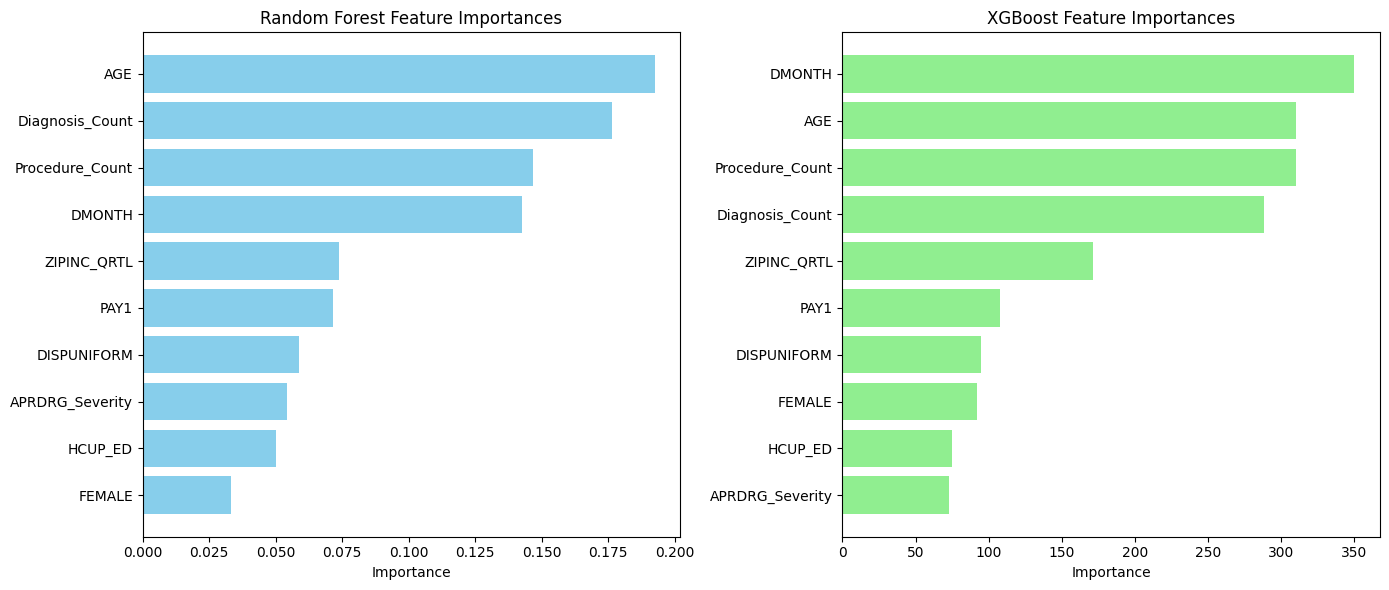

In [39]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Random Forest Importances
axes[0].barh(rf_importances_df.index, rf_importances_df['Importance'], color='skyblue')
axes[0].set_title('Random Forest Feature Importances')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis() 
# XGBoost Importances
axes[1].barh(xgb_importances_df.index, xgb_importances_df['Importance'], color='lightgreen')
axes[1].set_title('XGBoost Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()  # Invert axis to have the highest importance on top

plt.tight_layout()
plt.show()